In [1]:
import tensorflow as tf
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [57]:
# Imports 3 years of BTC daily data from yahoo finance
BTC_df = get_data("BTC-USD", start_date="6/30/2019", end_date="06/30/2022", index_as_date = True, interval="1d")
df = BTC_df.iloc[:,0:-1]
df.head()

,open,high,low,close,adjclose,volume
2019-06-30,11931.991211,12178.383789,10799.008789,10817.155273,10817.155273,27256473494
2019-07-01,10796.930664,11206.439453,10089.314453,10583.134766,10583.134766,29378589324
2019-07-02,10588.683594,10912.188477,9737.884766,10801.677734,10801.677734,31015895223
2019-07-03,10818.156250,11968.078125,10818.156250,11961.269531,11961.269531,30796494294
2019-07-04,11972.718750,12006.075195,11166.569336,11215.437500,11215.437500,25920294033


In [51]:
# Defines function to split X and y data
def window_data(df, window, feature_col_number, target_col_number):
    # Creates empty X and y list
    X = []
    y = []
    # loops through btc data
    for i in range(len(df) - window - 1):
        # splits the features by grouping window amount of previous close data
        features = df.iloc[i:(i + window), feature_col_number]
        # splits target by taking current close values
        target = df.iloc[(i + window), target_col_number]
        # Adds end of each loops data to respective X and y list
        X.append(features)
        y.append(target)
    # returns X,y as arrays
    return np.array(X), np.array(y).reshape(-1, 1)

In [52]:
# Defines window size
window_size=10

In [6]:
# Runs function to split X and y data
X, y=window_data(df, window_size, 3, 3)
# Displays X and y
display(X)
display(y)

array([[10817.15527344, 10583.13476562, 10801.67773438, ...,
        11450.84667969, 12285.95800781, 12573.8125    ],
       [10583.13476562, 10801.67773438, 11961.26953125, ...,
        12285.95800781, 12573.8125    , 12156.51269531],
       [10801.67773438, 11961.26953125, 11215.4375    , ...,
        12573.8125    , 12156.51269531, 11358.66210938],
       ...,
       [20471.48242188, 19017.64257812, 20553.27148438, ...,
        21231.65625   , 21502.33789062, 21027.29492188],
       [19017.64257812, 20553.27148438, 20599.53710938, ...,
        21502.33789062, 21027.29492188, 20735.47851562],
       [20553.27148438, 20599.53710938, 20710.59765625, ...,
        21027.29492188, 20735.47851562, 20280.63476562]])

array([[12156.51269531],
       [11358.66210938],
       [11815.98632812],
       ...,
       [20735.47851562],
       [20280.63476562],
       [20104.0234375 ]])

In [7]:
# Scales X and y data using MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X)
X_scaled=X_scaler.transform(X)
y_scaler=MinMaxScaler()
y_scaler.fit(y)
y_scaled=y_scaler.transform(y)

In [9]:
# Defines where train and test data will be split (70% is train)
split=int(0.7*len(X_scaled))
# Splits train and test data
X_train=X_scaled[:split]
X_test=X_scaled[split:]
y_train=y_scaled[:split]
y_test=y_scaled[split:]

In [10]:
# Reshapes data into size LSTM can handle
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
display(X_train.shape)
display(X_test.shape)

(760, 10, 1)

(326, 10, 1)

In [11]:
# Creates neural network
model_btc=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model_btc.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_btc.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model_btc.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model_btc.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model_btc.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model_btc.add(output_layer)

2022-07-14 13:40:59.382149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Compiles model
model_btc.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [17]:
# Provides summary of model
model_btc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 10, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-traina

In [14]:
model_btc.fit(X_train, y_train, epochs=50)

Epoch 1/50
24/24 [==============================] - 4s 11ms/step - loss: 0.0619 - mean_squared_error: 0.0619
Epoch 2/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 3/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 5/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 6/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 7/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 8/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 9/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 10/50
24/24 [

11/11 [==============================] - 0s 4ms/step


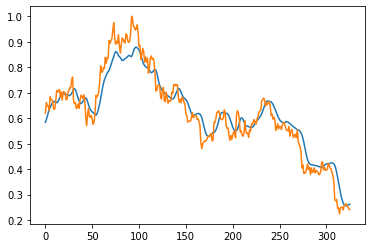

In [38]:
predictions = model_btc.predict(X_test)
results = pd.DataFrame({'predictions':predictions.ravel(),'actual':y_test.ravel()})
plt.plot(results)